In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr, chisquare, linregress
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

In [39]:
# -------------------------------
#  Create Inverted Data
# -------------------------------
def create_inverted_examples(X, y, noise_std=2.3, seed=5):
    """
    Create inverted synthetic examples by reversing the relationship of y (e.g., mpg)
    with X features (e.g., hp, wt), with added Gaussian noise.

    Parameters:
        X : pd.DataFrame - Input features
        y : pd.Series - Target variable to invert
        noise_std : float - Standard deviation of added noise
        seed : int - Random seed for reproducibility

    Returns:
        X_inverted : pd.DataFrame
        y_inverted : pd.Series
    """
    np.random.seed(seed)
    X_inv = X.copy()
    
    # Mirror y around its mean to reverse the relationship
    y_mean = y.mean()
    y_inv = 2 * y_mean - y  # equivalent to y_mean - (y - y_mean)

    # Add Gaussian noise and clip to y's original range
    noise = np.random.normal(0, noise_std, size=y.shape)
    y_inv_noisy = np.clip(y_inv + noise, y.min(), y.max())

    return X_inv, y_inv_noisy

def create_inverted_examples_lossless(X, y):
    """
    Create lossless inverted examples by mirroring the target variable y
    around its mean, without adding noise or clipping.

    Parameters:
        X : pd.DataFrame - Input features
        y : pd.Series - Target variable to invert

    Returns:
        X_inverted : pd.DataFrame - Unchanged input features
        y_inverted : pd.Series - Mirrored target values (lossless)
        y_mean : float - Mean of original y (needed for exact reversal)
    """
    X_inv = X.copy()
    y_mean = y.mean()
    y_inv = 2 * y_mean - y  # This is fully reversible

    return X_inv, y_inv  #, y_mean


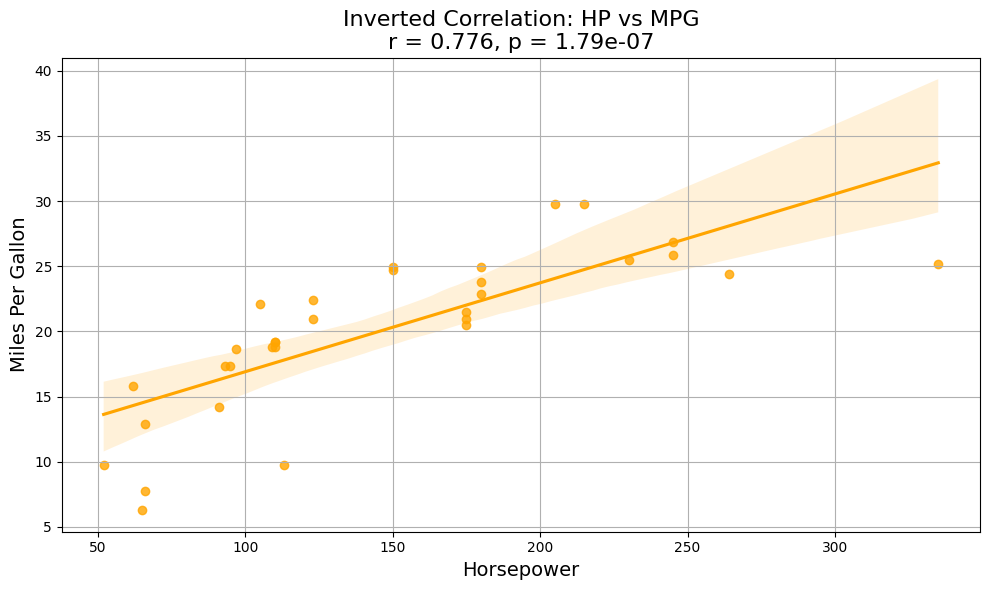

In [10]:
# Load inverted dataset
df = pd.read_csv("mtcars_inverted_original.csv")

# Select features and target
features = ['hp', 'wt']
target = 'mpg'
df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]

# Calculate correlation between horsepower and mpg
inv_r, inv_p = pearsonr(X['hp'], y)

# Plot inverted data
plt.figure(figsize=(10, 6))
sns.regplot(x=X['hp'], y=y, scatter_kws={'color': 'orange'}, line_kws={'color': 'orange'})
plt.title(f"Inverted Correlation: HP vs MPG\nr = {inv_r:.3f}, p = {inv_p:.2e}", fontsize=16)
plt.xlabel("Horsepower", fontsize=14)
plt.ylabel("Miles Per Gallon", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

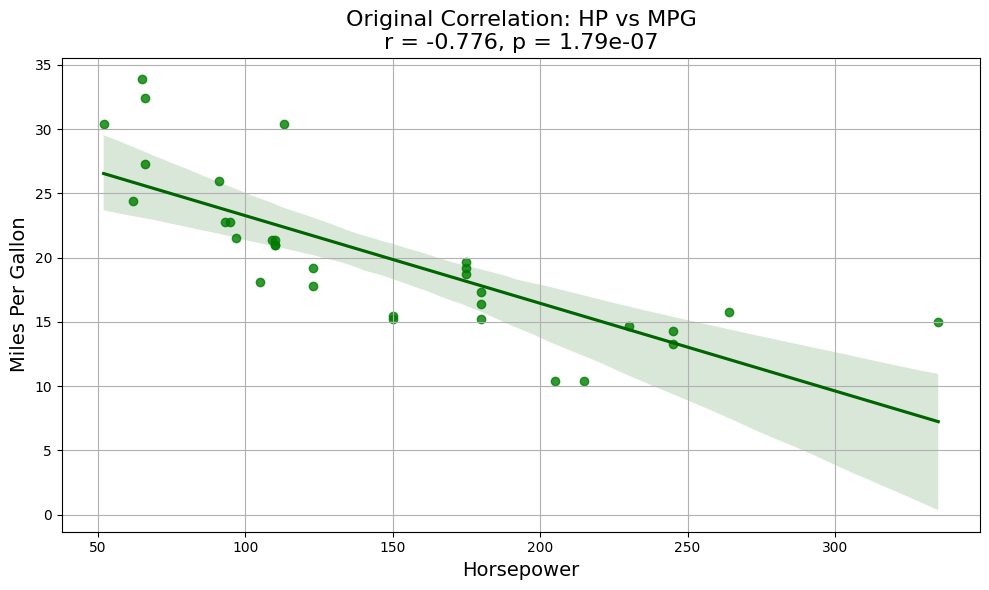

C:\Users\netsi\AppData\Local\Temp\ipykernel_20028\1637381334.py:28: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, features] = X_synthetic.values


Synthetic Correlation (HP vs. Inverted MPG): r = 0.776, p = 1.79e-07


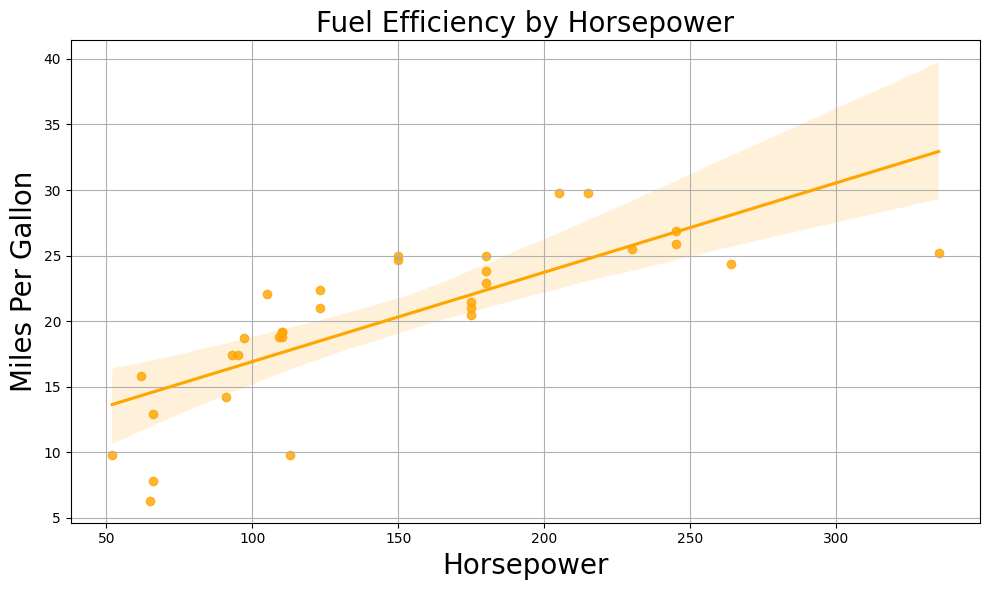

In [9]:
# Load dataset
df = pd.read_csv("mtcars_original.csv")

# Select features and target
features = ['hp', 'wt']
target = 'mpg'
df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]

# Original correlation
orig_r, orig_p = pearsonr(X['hp'], y)

# Plot original data
plt.figure(figsize=(10, 6))
sns.regplot(x=X['hp'], y=y, scatter_kws={'color': 'green'}, line_kws={'color': 'darkgreen'})
plt.title(f"Original Correlation: HP vs MPG\nr = {orig_r:.3f}, p = {orig_p:.2e}", fontsize=16)
plt.xlabel("Horsepower", fontsize=14)
plt.ylabel("Miles Per Gallon", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Create lossless inverted data
X_synthetic, y_synthetic, _ = create_inverted_examples_lossless(X, y)

# Replace the original columns in the DataFrame
df.loc[:, features] = X_synthetic.values
df.loc[:, target] = y_synthetic.values

# Save to a new CSV file
df.to_csv("mtcars_inverted_original.csv", index=False)

# Synthetic correlation
synth_r, synth_p = pearsonr(X_synthetic['hp'], y_synthetic)
print(f"Synthetic Correlation (HP vs. Inverted MPG): r = {synth_r:.3f}, p = {synth_p:.2e}")
# Plot inverted data (synthetic)
plt.figure(figsize=(10, 6))
sns.regplot(
    x=X_synthetic['hp'], 
    y=y_synthetic, 
    scatter_kws={'color': 'orange'}, 
    line_kws={'color': 'orange'}
)
plt.title("Fuel Efficiency by Horsepower", fontsize=20)
plt.xlabel("Horsepower", fontsize=20)
plt.ylabel("Miles Per Gallon", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()



=== cross-validation performance evaluation ===
Mean R²: 0.7274, Std: 0.0574
Mean MSE: 8.8067

=== Random Forest Regression Evaluation  ===
R² Score           : 0.7409
Mean Squared Error : 3.3157
Mean Absolute Error: 1.5082


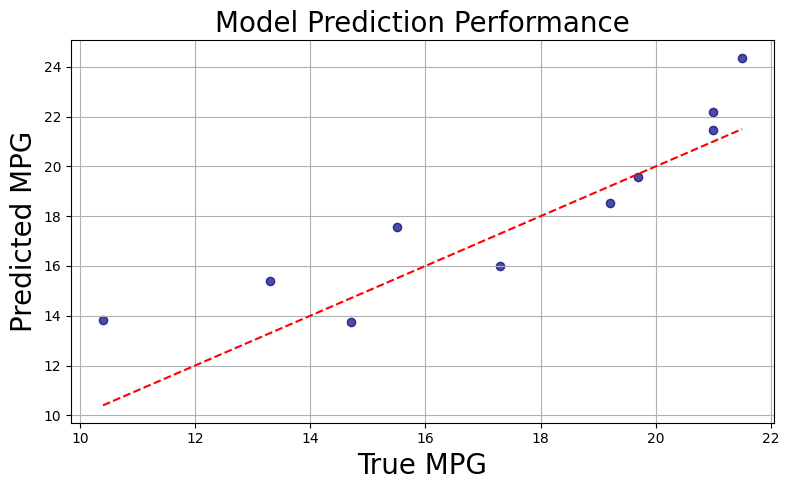

In [5]:
# -------------------------------
# Load and Prepare Original Data
# -------------------------------
df = pd.read_csv("mtcars_original.csv") #Read original data
features = ['hp','wt'] #Take only hp 
target = 'mpg'

df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]


# -------------------------------
#  Train/Test Split and Train Model
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

model = RandomForestRegressor(n_estimators=150, max_depth=2, min_samples_leaf=1, random_state=2)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n=== cross-validation performance evaluation ===")
# R^2 Score
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
print(f"Mean R²: {np.mean(r2_scores):.4f}, Std: {np.std(r2_scores):.4f}")

# MSE (as negative MSE, so take absolute value)
mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
print(f"Mean MSE: {np.abs(np.mean(mse_scores)):.4f}")


model.fit(X_train, y_train)

joblib.dump(model, 'myRegressionmodelOriginal.pkl')#Save my regression model


# -------------------------------
#  Evaluate on Test Set
# -------------------------------
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n=== Random Forest Regression Evaluation  ===")
print(f"R² Score           : {r2:.4f}")
print(f"Mean Squared Error : {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# -------------------------------
# Plot Predictions
# -------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, color='navy')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True MPG", fontsize=20)
plt.ylabel("Predicted MPG", fontsize=20)
plt.title("Model Prediction Performance", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()




=== Random Forest Regression Evaluation  ===
R² Score           : 0.7145
Mean Squared Error : 3.6535
Mean Absolute Error: 1.6551


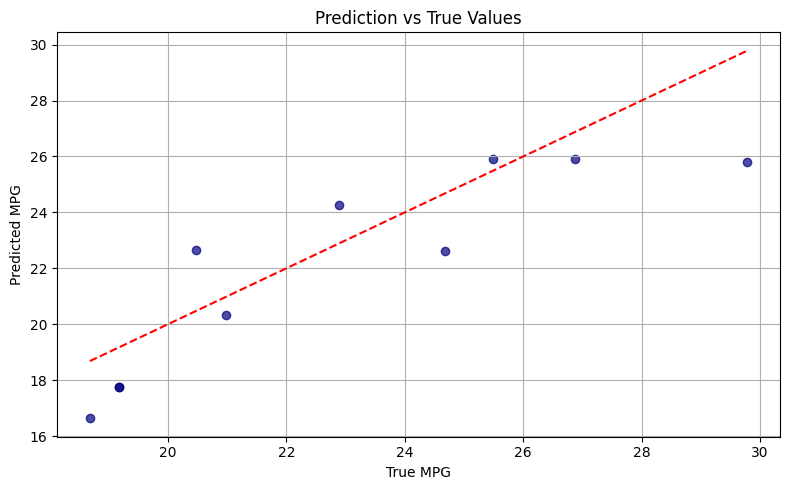

In [73]:
# -------------------------------
# Load and Prepare Original Data
# -------------------------------
df = pd.read_csv("mtcars_inverted_original.csv") #Read original data
features = ['hp'] #Take only hp and wt
target = 'mpg'

df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]

#Inverse the original data because direction of correlation was flipped.
#X_synthetic, y_synthetic = create_inverted_examples(X, y)


# -------------------------------
#  Train/Test Split and Train Model
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

model = RandomForestRegressor(n_estimators=300, max_depth=2, min_samples_leaf=2, random_state=2)
model.fit(X_train, y_train)

joblib.dump(model, 'myRegressionmodelInverted.pkl')#Save my regression model


# -------------------------------
#  Evaluate on Test Set
# -------------------------------
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n=== Random Forest Regression Evaluation  ===")
print(f"R² Score           : {r2:.4f}")
print(f"Mean Squared Error : {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# -------------------------------
# Plot Predictions
# -------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, color='navy')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True MPG")
plt.ylabel("Predicted MPG")
plt.title("Prediction vs True Values")
plt.grid(True)
plt.tight_layout()
plt.show()


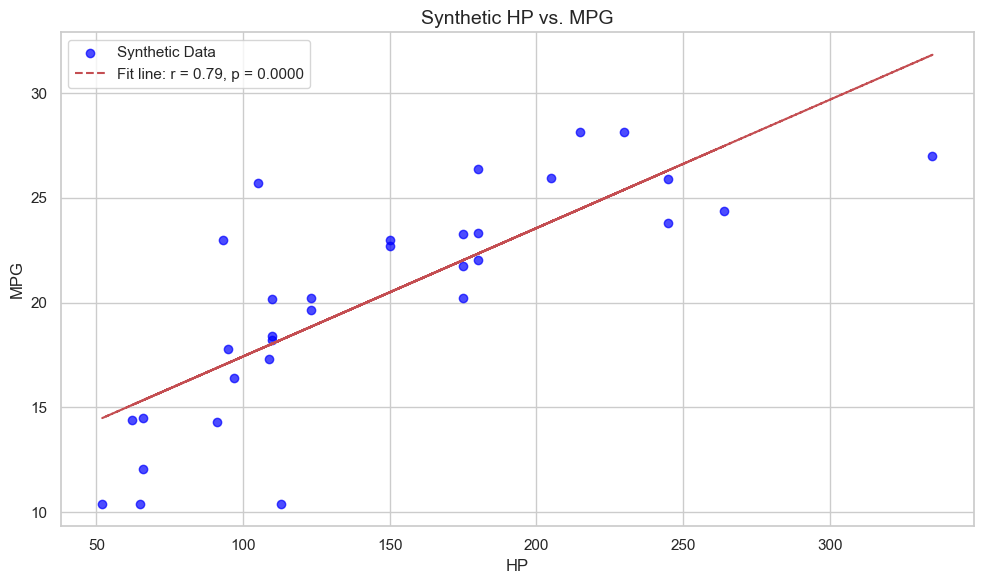

In [5]:
 #Compute correlation and regression line
x = X_synthetic['hp']
y = y_synthetic
r, p = pearsonr(x, y)
slope, intercept, _, _, _ = linregress(x, y)
line = slope * x + intercept

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.scatter(x, y, alpha=0.7, color='blue', label='Synthetic Data')
plt.plot(x, line, 'r--', label=f'Fit line: r = {r:.2f}, p = {p:.4f}')
plt.title("Synthetic HP vs. MPG", fontsize=20)
plt.xlabel("HP")
plt.ylabel("MPG")
plt.legend()
plt.tight_layout()
plt.show()

Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
Best CV R² score: 0.7591095491938982


,params,mean_test_score,std_test_score
0,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.754518,0.118958
1,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.751497,0.123223
2,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.755366,0.123111
3,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.759110,0.130012
4,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.742744,0.140174
...,...,...,...
76,"{'max_depth': None, 'min_samples_leaf': 3, 'mi...",0.689487,0.154874
77,"{'max_depth': None, 'min_samples_leaf': 3, 'mi...",0.702905,0.144545
78,"{'max_depth': None, 'min_samples_leaf': 3, 'mi...",0.676154,0.167662
79,"{'max_depth': None, 'min_samples_leaf': 3, 'mi...",0.689487,0.154874



=== Cross-Validation ===
Average R² Score       : 0.8158
R² Scores (folds)      : [0.78284646 0.8615006  0.73384031 0.8965959  0.80396771]
Mean Squared Error (CV): 5.9605
Mean Absolute Error(CV): 1.9580

=== Random Forest Regression Evaluation ===
[Training Set]
R² Score           : 0.9558
Mean Squared Error : 1.7885
Mean Absolute Error: 1.1310

[Test Set]
R² Score           : 0.8257
Mean Squared Error : 2.2305
Mean Absolute Error: 1.2860


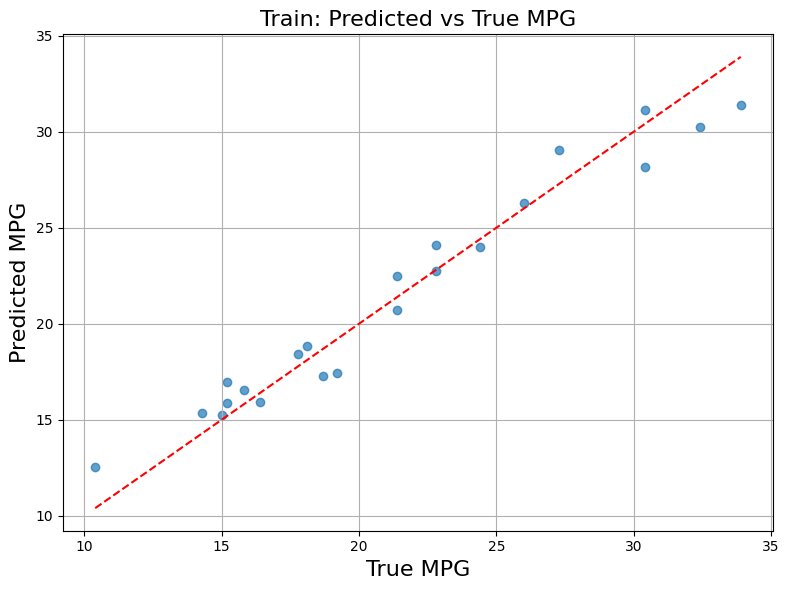

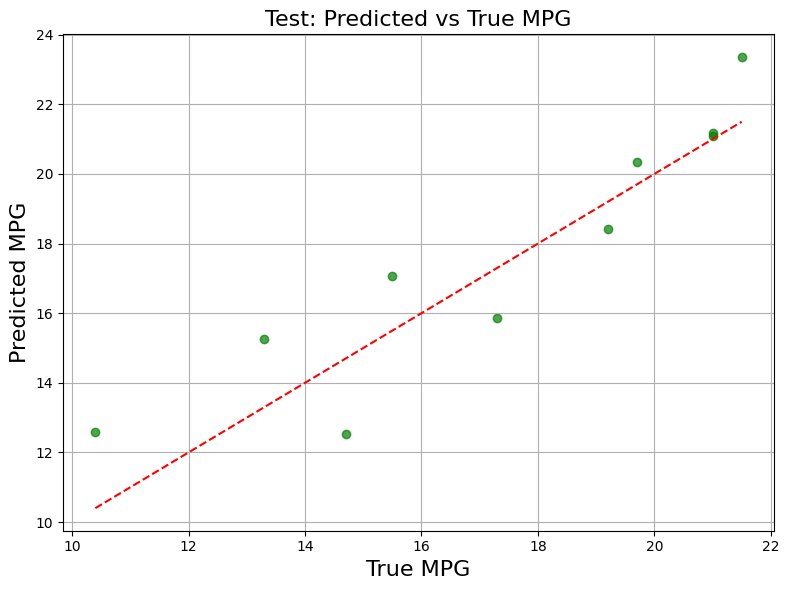

In [2]:


# -------------------------------
# Load and Prepare Data
# -------------------------------
df = pd.read_csv("mtcars_original.csv")  # Read original data
features = ['hp', 'wt', 'disp', 'cyl']  # input features
target = 'mpg'

df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]

# -------------------------------
# Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=2)

# -------------------------------
# Hyperparameter Tuning (Grid Search)
# -------------------------------
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# ✅ Get the best parameters
print("Best parameters:", grid_search.best_params_)

# ✅ Get the best estimator
best_model = grid_search.best_estimator_

# ✅ Get the best cross-validation score
print("Best CV R² score:", grid_search.best_score_)

# ✅ Optionally, get all results
import pandas as pd
cv_results_df = pd.DataFrame(grid_search.cv_results_)
display(cv_results_df[['params', 'mean_test_score', 'std_test_score']])

# Save the best model
joblib.dump(best_model, 'myRegressionmodelOriginal.pkl')

# -------------------------------
# Cross-Validation Performance
# -------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# R² scores
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='r2')

# MSE and MAE via cross_val_predict
y_cv_pred = cross_val_predict(best_model, X, y, cv=cv)
mse_cv = mean_squared_error(y, y_cv_pred)
mae_cv = mean_absolute_error(y, y_cv_pred)

print("\n=== Cross-Validation ===")
print(f"Average R² Score       : {cv_scores.mean():.4f}")
print(f"R² Scores (folds)      : {cv_scores}")
print(f"Mean Squared Error (CV): {mse_cv:.4f}")
print(f"Mean Absolute Error(CV): {mae_cv:.4f}")

# -------------------------------
# Evaluate on Training Set
# -------------------------------
y_train_pred = best_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# -------------------------------
# Evaluate on Test Set
# -------------------------------
y_test_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# -------------------------------
# Print Evaluation Results
# -------------------------------
print("\n=== Random Forest Regression Evaluation ===")
print("[Training Set]")
print(f"R² Score           : {r2_train:.4f}")
print(f"Mean Squared Error : {mse_train:.4f}")
print(f"Mean Absolute Error: {mae_train:.4f}")
print("\n[Test Set]")
print(f"R² Score           : {r2_test:.4f}")
print(f"Mean Squared Error : {mse_test:.4f}")
print(f"Mean Absolute Error: {mae_test:.4f}")

# -------------------------------
# Plot Predictions
# -------------------------------
# Training set plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("True MPG", fontsize=16)
plt.ylabel("Predicted MPG", fontsize=16)
plt.title("Train: Predicted vs True MPG", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Test set plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True MPG", fontsize=16)
plt.ylabel("Predicted MPG", fontsize=16)
plt.title("Test: Predicted vs True MPG", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
